In [ ]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

from dd_kable_analysis.config_loader import load_config
from dd_kable_analysis.data_io import (
    load_tsv_data,
    resolve_file,
)

# What is this?
I was curious whether there were warmup scans or not in this data set.  I didn't think so based on visual inspection of a couple of BOLD data sets, but noticed the design matrices show a lot of baseline prior to the task beginning.

## How do I check for warmup scans?
fMRIPrep automatically detects non–steady-state volumes at the beginning of each BOLD run using an intensity-based heuristic. Specifically, it examines the global signal across volumes and identifies early time points whose mean signal deviates from the stabilized baseline. When detected, these volumes are encoded in the confounds file (*_desc-confounds_timeseries.tsv) as one-hot regressors named non_steady_state_outlierXX, where each column corresponds to a single identified volume.

Below I check all confound files for these columns and tally up how many volumes were identified as warmup scans.  As I suspected, there are very few warmup scans.

In [2]:
cfg = load_config()
good_subs_csv = cfg.subject_lists / 'initial_qa_pass_subjects_runs.csv'
good_subs = pd.read_csv(good_subs_csv)

In [3]:
# looking for non_steady columns in confounds
get_nonsteady_vol_num = re.compile(r'non_steady_state_outlier(\d+)')

nonsteady_vols_all = []


for row in good_subs.itertuples(index=False):
    sub_id = row.sub_id
    run = row.run

    confound_file = resolve_file(cfg, sub_id, 'scan1', run, 'confounds')
    confounds = load_tsv_data(confound_file)
    non_steady_vols = [
        get_nonsteady_vol_num.search(col).groups()[0]
        for col in confounds.columns
        if 'non_steady' in col
    ]
    nonsteady_vols_all.append(non_steady_vols)

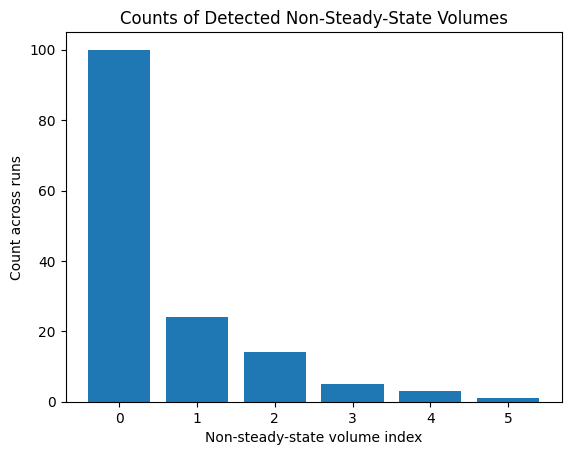

In [4]:
# Flatten list of lists and convert to integers
flat_nonsteady = [int(v) for sublist in nonsteady_vols_all for v in sublist]

if len(flat_nonsteady) == 0:
    print('No non-steady-state volumes detected.')
else:
    counts = Counter(flat_nonsteady)

    # Sort by volume index
    sorted_items = sorted(counts.items())
    x_vals = [item[0] for item in sorted_items]
    y_vals = [item[1] for item in sorted_items]

    plt.figure()
    plt.bar(x_vals, y_vals)
    plt.xlabel('Non-steady-state volume index')
    plt.ylabel('Count across runs')
    plt.title('Counts of Detected Non-Steady-State Volumes')
    plt.show()

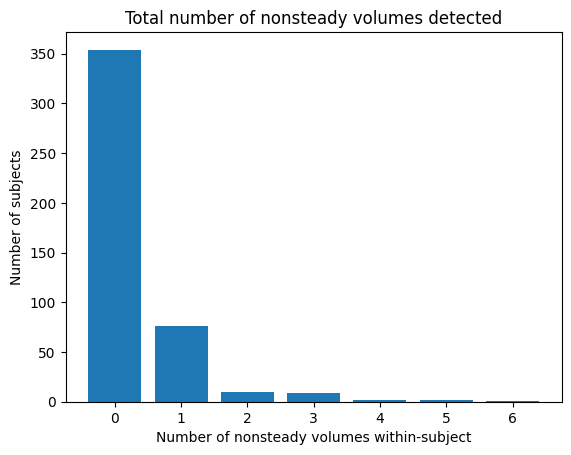

In [6]:
num_nonsteady = [len(vols) for vols in nonsteady_vols_all]
num_nonsteady, num_subjects = np.unique(num_nonsteady, return_counts=True)

plt.figure()
plt.bar(num_nonsteady, num_subjects)
plt.xlabel('Number of nonsteady volumes within-subject')
plt.ylabel('Number of subjects')
plt.title('Total number of nonsteady volumes detected')
plt.show()
